### Banking Discipline and Elasticity
J M Applegate.
##### CAS543 Complexity Economics
The notebook presents basic banking discipline and elasticity dynamics.  
A set of $n$ of retail customers are served by $N$ banks.  
Banks hold reserves as a central bank according to a specified reserve requirement.  
Customer transactions take place every day, and every night the reserve accounts need to be non-negative.  
Surplus banks lend to deficit banks as requested to meet the overnight non-negative reserve requirement.  

In [10]:
# import packages
from ipywidgets import widgets
from IPython.display import display, clear_output, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import seaborn as sns
import random
rng = np.random.default_rng()

In [11]:
# set parameters
n = 1000 # number of retail customers
N = 10 # number of banks
steps = 888 # number of simulation runs
tau = 200 # parameter for poisson function, mean number of transactions a step
reserve_reqmt = .5 # percentage of initial retail deposits as reserves
cb_rate = .2 # central bank lending rate
bailouts_are_allowed = True
backstop_rate = .25 # central bank backstop rate
bailout_deficit_multiplier = 1.1 # multiplier on current deficit to calculate bailout amount. this is not ideal but we lack global state
premium_basis = .01 # basis for risk premium
broker_network_fraction = 1 # TODO isnʻt working as intended. fraction of banks that can be "reached" by a broker 
max_balance = 100 # upper limit for initial retail deposits

Updates: We have added a risk assessment and pricing component to the intrabank lending model. `update_net_positions` updates a risk assessment factor for each bank based on how they are positioned with respect to their reserve requirements. `get_lender_quote` is called for every lender to obtain a priced proposition for a loan to the bank in question based on the risk assessment. 

In [12]:
# define utility function

# New!
def get_lender_quote(lender, borrower, reserves, net_positions, risk_appetites, cb_rate):
    # get_lender_quote simulates a agent shopping for quotes for overnight loans
    # thus giving us a pricing mechanism based on risk preference

    risk_premium = max(premium_basis, -net_positions[borrower]) * premium_basis # always charge at least cb_rate + premium_basis
    
    # factor in the lender's risk appetite
    adjusted_premium = risk_premium * (1 - risk_appetites[lender])

    # calculate with an arbitrary upper bound of 3x the cb_rate
    quote = min(cb_rate + adjusted_premium, 3 * cb_rate)

    # display(f"Lender {lender} has a risk appetite of {risk_appetites[lender]}")
    # display(f"Borrower {borrower} has a net position of {net_positions[borrower]}")
    # display(f"The adjusted premium for lender {lender} is {adjusted_premium}")
    # display(f"The quote for lender {lender} is {quote}")

    return (quote, True)

# New!
def calculate_avg_overnight_rate(loans, rates):
    total_weighted_cost = 0
    total_loan_volume = 0
    
    # Sum up (loan * rate) for all loans
    for bank_loans, bank_rates in zip(loans, rates):
        for loan, rate in zip(bank_loans, bank_rates):
            total_weighted_cost += loan * rate
            total_loan_volume += loan
    
    # Calculate weighted average, return 0 if no loans
    if total_loan_volume > 0:
        return total_weighted_cost / total_loan_volume
    return 0

# define model functions

# New!
def update_net_positions(N, loans, rates, reserves, customers, banks, balances):
    # For all of our banks, we want to calculate how well they are keeping up with the reserve requirement
    # This is sort of a proxy for bank health in light of the fact that
    # loans in the model are simulated rather than operational.
    # Note that this could also be calculated on the spot from reserves and loans, but
    # that would be a pain in the neck. Also, maybe we would want to get more clever about
    # bank health in the future.
    
    # Initialize net positions list
    net_positions = []
    
    # Calculate required reserves for each bank
    for B in range(N):
        # Calculate total deposits for this bank
        bank_deposits = 0
        for c in range(len(customers)):
            if banks[c] == B:
                bank_deposits += balances[c]
                
        required_reserves = bank_deposits * reserve_reqmt
        
        # Calculate loan costs
        loan_principal = sum(loans[B])
        
        # Calculate interest costs
        interest_cost = 0
        for loan, rate in zip(loans[B], rates[B]):
            interest_cost += loan * rate
        
         # Calculate net position as a ratio to required reserves
        if required_reserves > 0:  # Avoid division by zero
            net_position = (reserves[B] - loan_principal - interest_cost - required_reserves) / required_reserves
        else:
            net_position = 0 # TODO not sure about conditions with no required reserves
        
        net_positions.append(net_position)
    return net_positions

# Existing!
# create reserves from retail deposit amounts
def create_reserves(N, customers, banks, balances, reserve_reqmt):
    deposits = []
    for B in range(N):
        bank_deposits = 0
        for c in customers:
            if banks[c] == B:
                bank_deposits += balances[c]
        deposits.append(bank_deposits)
    reserves = [reserve_reqmt * d for d in deposits]
    return(reserves)

# retail customers conduct transactions which are settled through aggregated central bank reserve transfers
def retail_transactions(tau, customers, banks, balances, reserves):
    transfers = rng.poisson(tau)
    originators = random.choices(customers, weights = balances, k=transfers) # originators weighted on bank balances
    #originators = random.choices(customers, k=transfers) #unwe
    percentages = rng.random(transfers).tolist()
    recipients = []
    for o in originators:
        others = [c for c in customers if c != o]
        other_balances = [b for i, b in enumerate(balances) if i != o] 
        recipient = random.choices(others, weights = other_balances)[0] # recipients weighted on bank balances
        #recipient = random.choices(others)[0]
        recipients.append(recipient)
    originating_banks = [banks[o] for o in originators]
    receiving_banks = [banks[r] for r in recipients]
    for t in range(transfers):
        amount = percentages[t] * balances[originators[t]]
        balances[recipients[t]] += amount
        balances[originators[t]] -= amount
        reserves[receiving_banks[t]] += amount
        reserves[originating_banks[t]] -= amount
    return(balances, reserves)

# surplus banks lend to deficit banks at the end of the day to ensure all reserve accounts are non-negative
def settle_deficits(N, reserves, loans, rates, lenders, net_positions, risk_appetites):
    # in the unlikely event of a bailout...
    bailouts = []

    deficit_banks = [i for i, b in enumerate(reserves) if b < 0]
    possible_lenders = [x for x in range(N) if x not in deficit_banks]
    # Fed borrowers cannot offer quotes, so remove any possible lender with a loan from None
    possible_lenders = [x for x in possible_lenders if lenders[x] is not None]
    random.shuffle(possible_lenders)

    # in order to settle deficits, we need to get quotes from lenders
    # we simulate using a broker with "limited reach" to other banks
    # the broker will then choose the lowest quote and lend to the borrower

    broker_reach = int(N * broker_network_fraction)

    for i in deficit_banks:
        if len(possible_lenders) >= broker_reach:
            selected_lenders = random.sample(possible_lenders, broker_reach)
        else:
            selected_lenders = possible_lenders
            
        # Get quotes from each selected lender
        quotes = []
        for lender in selected_lenders:            
            quote, can_lend = get_lender_quote(
                lender, i, reserves, net_positions, 
                risk_appetites, cb_rate
            )
            if can_lend:
                quotes.append((lender, quote))
    
        # order the quotes by the quote amount
        if quotes:
            lowest_quotes_first = sorted(quotes, key=lambda x: x[1])
            j = 0
            while reserves[i] < 0 and j < len(lowest_quotes_first):
                lender = lowest_quotes_first[j][0]
                quoted_rate = lowest_quotes_first[j][1]
                if reserves[lender] >= abs(reserves[i]):
                    reserves[lender] += reserves[i]
                    # display(f"Writing full loan to borrower {i} from lender {lender} for amount {abs(reserves[i])} at rate {quoted_rate}")
                    loans[i].append(abs(reserves[i]))
                    rates[i].append(quoted_rate)
                    lenders[i].append(lender)
                    reserves[i] = 0
                    # display(f"Lender {lender} has {reserves[lender]} reserves remaining. Borrower {i} has {reserves[i]} reserves remaining.")
                elif reserves[lender] > 0:
                    # display(f"Writing partial loan to borrower {i} from lender {lender} for amount {reserves[lender]} at rate {quoted_rate}")
                    loans[i].append(reserves[lender])
                    rates[i].append(quoted_rate)
                    lenders[i].append(lender)
                    reserves[i] += reserves[lender]
                    reserves[lender] = 0
                    # display(f"Lender {lender} has {reserves[lender]} reserves remaining. Borrower {i} has {reserves[i]} reserves remaining.")                    
                    j += 1
                else:
                    # display(f"Lender {lender} has no reserves to lend")
                    j += 1
        
    for i_bad in deficit_banks:
        # if we still have a deficit, we need to call the Fed
        # Fed will repay all the outstanding loans and then set the bankʻs reserves back to the recap amount
        # This will go onto the books as one loan from the fed, at the backstop rate
        # And then we will set the risk appetite to 0.01

        if reserves[i_bad] < 0:  # Removed bailouts_are_allowed check since we always need to resolve negatives
            display(f"Borrower {i_bad} needs a bailout")
            display(f"Borrower {i_bad} has {reserves[i_bad]} reserves")
            display(f"Borrower {i_bad} has {loans[i_bad]} loans")

            # First, repay all existing loans
            for idx, loan in enumerate(loans[i_bad]):
                lender = lenders[i_bad][idx]
                rate = rates[i_bad][idx]
                if lender is not None:  # if it's not already a Fed loan
                    reserves[lender] += loan * (1 + rate)  # Repay with interest

            # now reset the bank
            recap_amount = max_balance * bailout_deficit_multiplier
            display(f"Borrower {i_bad} needs a bailout of {recap_amount}")
            loans[i_bad] = [recap_amount] # REPLACE the loans, donʻt append. Fed ensures all outstanding debt is repaid.
            rates[i_bad] = [backstop_rate]
            lenders[i_bad] = [None]
            reserves[i_bad] = recap_amount
            risk_appetites[i_bad] = 0.01
            bailouts.append((i_bad, recap_amount))
            
            display(f"Fed bailout complete. Borrower {i_bad} now has {loans[i_bad]} loans and {reserves[i_bad]} reserves.")

    return(reserves, loans, rates, lenders, bailouts)

# borrowing banks repay overnight loans
def repay_loans(N, loans, rates, lenders, reserves):
    for B in range(N):
        for i, loan in enumerate(loans[B]):
            rate = rates[B][i] # stored right alongside the loans now, cb_rate baked in.
            lender = lenders[B][i]

            # if lender is  None, itʻs a fed loan
            if lender is not None: # normal interbank loan
                reserves[lender] += loan * (1 + rate)
            # but, still need to deduct from borrowing bank whether Fed or other bank
            reserves[B] -= loan * (1 + rate)

            loans[B].pop(0)
            rates[B].pop(0)
            lenders[B].pop(0)
    return(loans, rates, lenders, reserves)

In [13]:
# initialise data structures
customers = list(range(n))
banks = rng.choice(range(N), n).tolist()
balances = rng.uniform(1, max_balance, n).tolist()
loans = [[] for _ in range(N)]
rates = [[] for _ in range(N)]
lenders = [[] for _ in range(N)]
customer_history = pd.DataFrame()
bank_history = pd.DataFrame()
financial_system_history = pd.DataFrame()

# calculate reserves based on retail deposits
reserves = create_reserves(N, customers, banks, balances, reserve_reqmt)

# we should now be able to initialize our asset positions
net_positions = update_net_positions(N, loans, rates, reserves, customers, banks, balances)

# and our risk appetites are simple enough...
risk_appetites = rng.uniform(0, 0.5, N).tolist()

# populate history arrays with initial values
customer_history['step'] = [0] * n
customer_history['id'] = customers
customer_history['balance'] = balances
bank_history['step'] = [0] * N
bank_history['id'] = list(range(N))
bank_history['reserves'] = reserves
bank_history['loans'] = [sum(l0) for l0 in loans]
bank_history['rates'] = [[] for _ in range(N)]
bank_history['net_positions'] = net_positions
bank_history['risk_appetite'] = risk_appetites
# these are vectors but only one history for the whole system. so, no "N"
financial_system_history['step'] = [0]
financial_system_history['average_net_position'] = [0]
financial_system_history['avg_daily_rate'] = [0]
financial_system_history['average_risk_appetite'] = [0]
financial_system_history['fed_recapitalization'] = [None] # 0 to many banks can be taken over by the fed each step, store as list or None

for s in range(1, steps+1):

    display(f"Step {s}")
    
    #repay overnight loans
    loans, rates, lenders, reserves = repay_loans(N, loans, rates, lenders, reserves)
            
    #conduct retail customer activity
    balances, reserves = retail_transactions(tau, customers, banks, balances, reserves)

    #settle negative reserve accounts at end of day
    # note that we pass in the customers and banks in order to deal with bailout conditions
    reserves, loans, rates, lenders, bailouts = settle_deficits(N, reserves, loans, rates, lenders, net_positions, risk_appetites)

    #and finally update our net_positions
    net_positions = update_net_positions(N, loans, rates, reserves, customers, banks, balances)

    # store simulation values as dataframes
    customer_step = pd.DataFrame()
    bank_step = pd.DataFrame()
    financial_system_step = pd.DataFrame()

    customer_step['step'] = [s] * n
    customer_step['id'] = customers
    customer_step['balance'] = balances

    bank_step['step'] = [s] * N
    bank_step['id'] = list(range(N))
    bank_step['reserves'] = reserves
    bank_step['loans'] = [sum(l1) for l1 in loans]

    financial_system_step['step'] = [s]
    financial_system_step['avg_daily_rate'] = [calculate_avg_overnight_rate(loans, rates)]
    financial_system_step['average_net_position'] = [sum(net_positions) / N]
    financial_system_step['average_risk_appetite'] = [sum(risk_appetites) / N]
    financial_system_step['fed_recapitalization'] = [bailouts]


    customer_history = pd.concat([customer_history, customer_step], ignore_index=True)
    bank_history = pd.concat([bank_history, bank_step], ignore_index=True)
    financial_system_history = pd.concat([financial_system_history, financial_system_step], ignore_index=True)

'Step 1'

'Step 2'

'Step 3'

'Step 4'

'Step 5'

'Step 6'

'Step 7'

'Step 8'

'Step 9'

'Step 10'

'Step 11'

'Step 12'

'Step 13'

'Step 14'

'Step 15'

'Step 16'

'Step 17'

'Step 18'

'Step 19'

'Step 20'

'Step 21'

'Step 22'

'Step 23'

'Step 24'

'Step 25'

'Step 26'

'Step 27'

'Step 28'

'Step 29'

'Step 30'

'Step 31'

'Step 32'

'Step 33'

'Step 34'

'Step 35'

'Step 36'

'Step 37'

'Step 38'

'Step 39'

'Step 40'

'Step 41'

'Step 42'

'Step 43'

'Step 44'

'Step 45'

'Step 46'

'Step 47'

'Step 48'

'Step 49'

'Step 50'

'Step 51'

'Step 52'

'Step 53'

'Step 54'

'Step 55'

'Step 56'

'Step 57'

'Step 58'

'Step 59'

'Step 60'

'Step 61'

'Step 62'

'Step 63'

'Step 64'

'Step 65'

'Step 66'

'Step 67'

'Step 68'

'Step 69'

'Step 70'

'Step 71'

'Step 72'

'Step 73'

'Step 74'

'Step 75'

'Step 76'

'Step 77'

'Step 78'

'Step 79'

'Step 80'

'Step 81'

'Step 82'

'Step 83'

'Step 84'

'Step 85'

'Step 86'

'Step 87'

'Step 88'

'Step 89'

'Step 90'

'Step 91'

'Step 92'

'Step 93'

'Step 94'

'Step 95'

'Step 96'

'Step 97'

'Step 98'

'Step 99'

'Step 100'

'Step 101'

'Step 102'

'Step 103'

'Step 104'

'Step 105'

'Step 106'

'Step 107'

'Step 108'

'Step 109'

'Step 110'

'Step 111'

'Step 112'

'Step 113'

'Step 114'

'Step 115'

'Step 116'

'Step 117'

'Step 118'

'Step 119'

'Step 120'

'Step 121'

'Step 122'

'Step 123'

'Step 124'

'Step 125'

'Step 126'

'Step 127'

'Step 128'

'Step 129'

'Step 130'

'Step 131'

'Step 132'

'Step 133'

'Step 134'

'Step 135'

'Step 136'

'Step 137'

'Step 138'

'Step 139'

'Step 140'

'Step 141'

'Step 142'

'Step 143'

'Step 144'

'Step 145'

'Step 146'

'Step 147'

'Step 148'

'Step 149'

'Step 150'

'Step 151'

'Step 152'

'Step 153'

'Step 154'

'Step 155'

'Step 156'

'Step 157'

'Step 158'

'Step 159'

'Step 160'

'Step 161'

'Step 162'

'Step 163'

'Step 164'

'Step 165'

'Step 166'

'Step 167'

'Step 168'

'Step 169'

'Step 170'

'Step 171'

'Step 172'

'Step 173'

'Step 174'

'Step 175'

'Step 176'

'Step 177'

'Step 178'

'Step 179'

'Step 180'

'Step 181'

'Borrower 9 needs a bailout'

'Borrower 9 has -2912.0 reserves'

'Borrower 9 has [1.255282147632087e+17] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 182'

'Step 183'

'Step 184'

'Step 185'

'Step 186'

'Step 187'

'Step 188'

'Step 189'

'Step 190'

'Step 191'

'Step 192'

'Step 193'

'Step 194'

'Step 195'

'Step 196'

'Step 197'

'Step 198'

'Step 199'

'Step 200'

'Step 201'

'Step 202'

'Step 203'

'Step 204'

'Step 205'

'Step 206'

'Step 207'

'Step 208'

'Step 209'

'Step 210'

'Step 211'

'Step 212'

'Step 213'

'Step 214'

'Step 215'

'Step 216'

'Step 217'

'Step 218'

'Step 219'

'Step 220'

'Step 221'

'Step 222'

'Step 223'

'Step 224'

'Step 225'

'Step 226'

'Step 227'

'Step 228'

'Step 229'

'Step 230'

'Step 231'

'Step 232'

'Step 233'

'Step 234'

'Step 235'

'Step 236'

'Step 237'

'Step 238'

'Step 239'

'Step 240'

'Step 241'

'Step 242'

'Borrower 9 needs a bailout'

'Borrower 9 has -52365324581942.984 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 243'

'Step 244'

'Step 245'

'Step 246'

'Step 247'

'Borrower 8 needs a bailout'

'Borrower 8 has -1.8446744073709552e+19 reserves'

'Borrower 8 has [4.368392896738974e+34] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 248'

'Step 249'

'Step 250'

'Step 251'

'Step 252'

'Step 253'

'Step 254'

'Step 255'

'Step 256'

'Step 257'

'Step 258'

'Step 259'

'Step 260'

'Step 261'

'Step 262'

'Step 263'

'Step 264'

'Step 265'

'Step 266'

'Step 267'

'Step 268'

'Step 269'

'Step 270'

'Step 271'

'Step 272'

'Step 273'

'Step 274'

'Step 275'

'Step 276'

'Step 277'

'Step 278'

'Step 279'

'Step 280'

'Step 281'

'Step 282'

'Step 283'

'Step 284'

'Step 285'

'Step 286'

'Step 287'

'Step 288'

'Step 289'

'Step 290'

'Step 291'

'Step 292'

'Step 293'

'Step 294'

'Step 295'

'Step 296'

'Step 297'

'Step 298'

'Step 299'

'Step 300'

'Step 301'

'Step 302'

'Step 303'

'Step 304'

'Step 305'

'Step 306'

'Step 307'

'Step 308'

'Step 309'

'Step 310'

'Step 311'

'Step 312'

'Step 313'

'Step 314'

'Step 315'

'Step 316'

'Step 317'

'Step 318'

'Step 319'

'Step 320'

'Step 321'

'Step 322'

'Step 323'

'Step 324'

'Step 325'

'Step 326'

'Step 327'

'Step 328'

'Step 329'

'Step 330'

'Step 331'

'Step 332'

'Step 333'

'Step 334'

'Borrower 8 needs a bailout'

'Borrower 8 has -7.721344693136574e+19 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -1.1635002307101873e+20 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 335'

'Borrower 7 needs a bailout'

'Borrower 7 has -6.64613997892458e+35 reserves'

'Borrower 7 has [4.7293781489296756e+51, 835.4466479164066] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -3372.5021888719493 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 336'

'Step 337'

'Step 338'

'Step 339'

'Step 340'

'Step 341'

'Step 342'

'Step 343'

'Step 344'

'Step 345'

'Step 346'

'Step 347'

'Step 348'

'Step 349'

'Step 350'

'Step 351'

'Step 352'

'Step 353'

'Step 354'

'Step 355'

'Step 356'

'Step 357'

'Step 358'

'Step 359'

'Step 360'

'Step 361'

'Step 362'

'Step 363'

'Step 364'

'Step 365'

'Step 366'

'Step 367'

'Step 368'

'Step 369'

'Step 370'

'Step 371'

'Step 372'

'Step 373'

'Step 374'

'Step 375'

'Step 376'

'Step 377'

'Step 378'

'Step 379'

'Step 380'

'Step 381'

'Step 382'

'Step 383'

'Step 384'

'Step 385'

'Step 386'

'Step 387'

'Step 388'

'Step 389'

'Step 390'

'Step 391'

'Step 392'

'Step 393'

'Step 394'

'Step 395'

'Step 396'

'Step 397'

'Step 398'

'Step 399'

'Step 400'

'Step 401'

'Step 402'

'Step 403'

'Step 404'

'Step 405'

'Step 406'

'Step 407'

'Step 408'

'Step 409'

'Step 410'

'Step 411'

'Step 412'

'Step 413'

'Step 414'

'Step 415'

'Step 416'

'Step 417'

'Step 418'

'Borrower 4 needs a bailout'

'Borrower 4 has -6.186967200940748e+36 reserves'

'Borrower 4 has [9.363175552111384e+36] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 5 needs a bailout'

'Borrower 5 has -6.91941013228714e+38 reserves'

'Borrower 5 has [1.391528133589343e+39] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -8.330968505120389e+18 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -8.827975414264839e+18 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -1.1730614788717074e+19 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 419'

'Step 420'

'Borrower 5 needs a bailout'

'Borrower 5 has -12862.077607188512 reserves'

'Borrower 5 has [109.43152768508094] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 421'

'Step 422'

'Step 423'

'Borrower 4 needs a bailout'

'Borrower 4 has -1748.4041580042267 reserves'

'Borrower 4 has [9074.715602095832] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -1953.0929132992799 reserves'

'Borrower 9 has [5087.478720405571] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 424'

'Step 425'

'Step 426'

'Borrower 5 needs a bailout'

'Borrower 5 has -368.77615850141046 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 427'

'Step 428'

'Step 429'

'Step 430'

'Borrower 7 needs a bailout'

'Borrower 7 has -3135.6195102914894 reserves'

'Borrower 7 has [1524.342552887901] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -2836.755564701104 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 431'

'Borrower 9 needs a bailout'

'Borrower 9 has -2128.38761880489 reserves'

'Borrower 9 has [4330.365246518641, 7881.075009400319] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 432'

'Step 433'

'Step 434'

'Step 435'

'Step 436'

'Step 437'

'Borrower 7 needs a bailout'

'Borrower 7 has -908.1671460402649 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -6849.811381384406 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -2927.875986759464 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 438'

'Step 439'

'Step 440'

'Borrower 4 needs a bailout'

'Borrower 4 has -3982.040161454491 reserves'

'Borrower 4 has [319.3524044944488] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -480.8480562051452 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -7199.097174553553 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 441'

'Borrower 8 needs a bailout'

'Borrower 8 has -103.02414024262805 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -1178.3080028352817 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 442'

'Step 443'

'Borrower 5 needs a bailout'

'Borrower 5 has -358.7948429550361 reserves'

'Borrower 5 has [1792.172237826534] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -4876.450553058897 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 444'

'Step 445'

'Step 446'

'Borrower 9 needs a bailout'

'Borrower 9 has -1630.1591574490585 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 447'

'Step 448'

'Step 449'

'Step 450'

'Step 451'

'Borrower 3 needs a bailout'

'Borrower 3 has -1.004336277661869e+59 reserves'

'Borrower 3 has [6.826781530249361e+74, 5187.552000748078, 1435.9911792617213, 27162925.001479097] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -5572.212343139507 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 452'

'Step 453'

'Step 454'

'Step 455'

'Step 456'

'Step 457'

'Step 458'

'Step 459'

'Step 460'

'Step 461'

'Step 462'

'Step 463'

'Step 464'

'Step 465'

'Step 466'

'Step 467'

'Step 468'

'Step 469'

'Step 470'

'Step 471'

'Step 472'

'Step 473'

'Step 474'

'Step 475'

'Step 476'

'Step 477'

'Step 478'

'Step 479'

'Step 480'

'Step 481'

'Step 482'

'Step 483'

'Step 484'

'Step 485'

'Step 486'

'Step 487'

'Step 488'

'Step 489'

'Step 490'

'Step 491'

'Step 492'

'Step 493'

'Step 494'

'Step 495'

'Step 496'

'Step 497'

'Step 498'

'Step 499'

'Step 500'

'Step 501'

'Step 502'

'Step 503'

'Step 504'

'Step 505'

'Step 506'

'Step 507'

'Step 508'

'Step 509'

'Step 510'

'Step 511'

'Step 512'

'Step 513'

'Step 514'

'Step 515'

'Step 516'

'Step 517'

'Step 518'

'Step 519'

'Step 520'

'Step 521'

'Step 522'

'Step 523'

'Step 524'

'Step 525'

'Step 526'

'Step 527'

'Step 528'

'Step 529'

'Step 530'

'Step 531'

'Step 532'

'Step 533'

'Step 534'

'Step 535'

'Step 536'

'Step 537'

'Step 538'

'Step 539'

'Step 540'

'Step 541'

'Step 542'

'Step 543'

'Step 544'

'Borrower 3 needs a bailout'

'Borrower 3 has -7.048195086867361e+17 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 4 needs a bailout'

'Borrower 4 has -1.6692210052930058e+19 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 5 needs a bailout'

'Borrower 5 has -6206290723305244.0 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -9.146784676545207e+19 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -6990862359398.128 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -1.7901007134349525e+20 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 545'

'Step 546'

'Borrower 3 needs a bailout'

'Borrower 3 has -2716.6326454626724 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 4 needs a bailout'

'Borrower 4 has -3303.2577797269278 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 5 needs a bailout'

'Borrower 5 has -3276.9568946729823 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -7929.372822723726 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 547'

'Borrower 3 needs a bailout'

'Borrower 3 has -1424.6384715007257 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 4 needs a bailout'

'Borrower 4 has -7357.6235988392955 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 548'

'Step 549'

'Step 550'

'Borrower 9 needs a bailout'

'Borrower 9 has -2760.9053337800187 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 551'

'Step 552'

'Step 553'

'Borrower 8 needs a bailout'

'Borrower 8 has -4479.909493532607 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 554'

'Step 555'

'Step 556'

'Step 557'

'Step 558'

'Step 559'

'Step 560'

'Borrower 5 needs a bailout'

'Borrower 5 has -2531.1036212441813 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -15734.364096399559 reserves'

'Borrower 8 has [294.2837503146611] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -3296.610624825188 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 561'

'Borrower 3 needs a bailout'

'Borrower 3 has -897.6747996880454 reserves'

'Borrower 3 has [7163.4362789904335, 1186.1134849347532] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 4 needs a bailout'

'Borrower 4 has -5136.46209273217 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 5 needs a bailout'

'Borrower 5 has -626.4101368189259 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 562'

'Borrower 3 needs a bailout'

'Borrower 3 has -4061.1329569291356 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 563'

'Step 564'

'Step 565'

'Step 566'

'Step 567'

'Borrower 3 needs a bailout'

'Borrower 3 has -3873.9735837653893 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 568'

'Borrower 5 needs a bailout'

'Borrower 5 has -1780.7485351665032 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 569'

'Step 570'

'Step 571'

'Step 572'

'Step 573'

'Step 574'

'Step 575'

'Step 576'

'Step 577'

'Step 578'

'Step 579'

'Step 580'

'Step 581'

'Step 582'

'Step 583'

'Step 584'

'Borrower 9 needs a bailout'

'Borrower 9 has -14840.36465631454 reserves'

'Borrower 9 has [8190.805164716416] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 585'

'Step 586'

'Borrower 4 needs a bailout'

'Borrower 4 has -1845.4499187800866 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 587'

'Step 588'

'Borrower 3 needs a bailout'

'Borrower 3 has -4128.631400386025 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 589'

'Borrower 9 needs a bailout'

'Borrower 9 has -3777.8267866462274 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 590'

'Step 591'

'Step 592'

'Step 593'

'Borrower 4 needs a bailout'

'Borrower 4 has -2733.9034704227925 reserves'

'Borrower 4 has [17497.45290968266] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 594'

'Step 595'

'Step 596'

'Step 597'

'Step 598'

'Step 599'

'Step 600'

'Borrower 3 needs a bailout'

'Borrower 3 has -4293.241757136009 reserves'

'Borrower 3 has [2410.5371086051127] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 601'

'Step 602'

'Step 603'

'Step 604'

'Borrower 3 needs a bailout'

'Borrower 3 has -25.368475306691607 reserves'

'Borrower 3 has [1610.941357281699] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 4 needs a bailout'

'Borrower 4 has -4657.8892951880625 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 5 needs a bailout'

'Borrower 5 has -20479.56419206996 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 605'

'Step 606'

'Step 607'

'Borrower 4 needs a bailout'

'Borrower 4 has -3961.753759420647 reserves'

'Borrower 4 has [2148.9070030163284] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 5 needs a bailout'

'Borrower 5 has -2240.3215734459855 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 608'

'Step 609'

'Step 610'

'Step 611'

'Step 612'

'Step 613'

'Borrower 3 needs a bailout'

'Borrower 3 has -6668.106176172289 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 5 needs a bailout'

'Borrower 5 has -3824.054022848873 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -214.78014210798176 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 614'

'Step 615'

'Borrower 4 needs a bailout'

'Borrower 4 has -6801.944346252193 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -3525.0868504548885 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -7245.478367553593 reserves'

'Borrower 9 has [387.32264142475015] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 616'

'Step 617'

'Borrower 7 needs a bailout'

'Borrower 7 has -1117.4330878003307 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 618'

'Borrower 3 needs a bailout'

'Borrower 3 has -2313.571343179838 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 5 needs a bailout'

'Borrower 5 has -16076.591483365923 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 619'

'Step 620'

'Step 621'

'Step 622'

'Borrower 8 needs a bailout'

'Borrower 8 has -6947.771379682123 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 623'

'Step 624'

'Step 625'

'Step 626'

'Step 627'

'Step 628'

'Step 629'

'Step 630'

'Step 631'

'Borrower 7 needs a bailout'

'Borrower 7 has -3057.039535458574 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 632'

'Borrower 7 needs a bailout'

'Borrower 7 has -27.500000000000014 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -3154.4670281235053 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 633'

'Step 634'

'Step 635'

'Step 636'

'Step 637'

'Borrower 5 needs a bailout'

'Borrower 5 has -11713.193365488407 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 638'

'Step 639'

'Step 640'

'Borrower 5 needs a bailout'

'Borrower 5 has -2879.5232209550645 reserves'

'Borrower 5 has [467.9780478810627] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 641'

'Step 642'

'Step 643'

'Step 644'

'Step 645'

'Step 646'

'Step 647'

'Borrower 8 needs a bailout'

'Borrower 8 has -1322.5074849169193 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 648'

'Borrower 7 needs a bailout'

'Borrower 7 has -3929.0749537890615 reserves'

'Borrower 7 has [1364.0218867320716] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 649'

'Step 650'

'Step 651'

'Step 652'

'Step 653'

'Borrower 4 needs a bailout'

'Borrower 4 has -4431.021918975644 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 5 needs a bailout'

'Borrower 5 has -10031.260859384152 reserves'

'Borrower 5 has [789.7211389868771] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 654'

'Step 655'

'Step 656'

'Step 657'

'Borrower 3 needs a bailout'

'Borrower 3 has -5643.53921811013 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -4540.570328563579 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -5405.6950835654 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 658'

'Step 659'

'Step 660'

'Step 661'

'Step 662'

'Borrower 3 needs a bailout'

'Borrower 3 has -2601.9729718107064 reserves'

'Borrower 3 has [4691.954315405405] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 663'

'Step 664'

'Step 665'

'Step 666'

'Step 667'

'Step 668'

'Borrower 9 needs a bailout'

'Borrower 9 has -9556.62299553512 reserves'

'Borrower 9 has [7693.370978370168] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 669'

'Borrower 4 needs a bailout'

'Borrower 4 has -6385.007675229127 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 5 needs a bailout'

'Borrower 5 has -3028.3025317927554 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -1793.0795977455691 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 670'

'Step 671'

'Step 672'

'Borrower 3 needs a bailout'

'Borrower 3 has -9080.064860145338 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 673'

'Step 674'

'Step 675'

'Step 676'

'Step 677'

'Step 678'

'Borrower 4 needs a bailout'

'Borrower 4 has -13337.153566805231 reserves'

'Borrower 4 has [536.0483495246945, 1579.058270919667] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -1136.1214384374275 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 679'

'Borrower 3 needs a bailout'

'Borrower 3 has -1844.856541543581 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 4 needs a bailout'

'Borrower 4 has -2183.8551922018833 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -1119.5672688506957 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 680'

'Step 681'

'Step 682'

'Step 683'

'Borrower 9 needs a bailout'

'Borrower 9 has -1021.4128913028553 reserves'

'Borrower 9 has [1685.3241668144415, 3517.221024106955] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 684'

'Step 685'

'Borrower 9 needs a bailout'

'Borrower 9 has -2216.392959468015 reserves'

'Borrower 9 has [791.5063194653794] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 686'

'Step 687'

'Step 688'

'Borrower 7 needs a bailout'

'Borrower 7 has -5167.847170564229 reserves'

'Borrower 7 has [3320.1944531228028, 666.6293000063988] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -425.08525464619277 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -638.4881593019309 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 689'

'Step 690'

'Step 691'

'Step 692'

'Borrower 3 needs a bailout'

'Borrower 3 has -9190.692686436556 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -1442.4226604092946 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -119.04203400393776 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 693'

'Step 694'

'Step 695'

'Step 696'

'Borrower 5 needs a bailout'

'Borrower 5 has -3800.103682148086 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -80.06418626814377 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 697'

'Step 698'

'Step 699'

'Step 700'

'Step 701'

'Step 702'

'Step 703'

'Step 704'

'Step 705'

'Step 706'

'Borrower 3 needs a bailout'

'Borrower 3 has -15341.246299718849 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -6750.749793135919 reserves'

'Borrower 7 has [4715.929922211875] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -2271.7663242155477 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 707'

'Borrower 3 needs a bailout'

'Borrower 3 has -2174.275461723983 reserves'

'Borrower 3 has [2823.021253871984] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 4 needs a bailout'

'Borrower 4 has -272.09469216067305 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 708'

'Step 709'

'Step 710'

'Step 711'

'Step 712'

'Borrower 3 needs a bailout'

'Borrower 3 has -7650.539494644933 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 4 needs a bailout'

'Borrower 4 has -17560.659647903372 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 713'

'Step 714'

'Borrower 9 needs a bailout'

'Borrower 9 has -12987.171281780373 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 715'

'Step 716'

'Step 717'

'Step 718'

'Step 719'

'Step 720'

'Step 721'

'Borrower 3 needs a bailout'

'Borrower 3 has -7130.726109641556 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -13310.019956949163 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 722'

'Step 723'

'Step 724'

'Step 725'

'Step 726'

'Step 727'

'Step 728'

'Step 729'

'Borrower 9 needs a bailout'

'Borrower 9 has -23158.04306008899 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 730'

'Borrower 3 needs a bailout'

'Borrower 3 has -2488.003670027623 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 5 needs a bailout'

'Borrower 5 has -3196.857278669005 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -466.69726512731086 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -1453.2363698560066 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 731'

'Step 732'

'Step 733'

'Step 734'

'Step 735'

'Step 736'

'Step 737'

'Borrower 8 needs a bailout'

'Borrower 8 has -1404.5586295954508 reserves'

'Borrower 8 has [15872.68890071865] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -25589.332797145173 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 738'

'Step 739'

'Step 740'

'Step 741'

'Step 742'

'Step 743'

'Step 744'

'Step 745'

'Step 746'

'Borrower 9 needs a bailout'

'Borrower 9 has -8819.196958539958 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 747'

'Step 748'

'Step 749'

'Borrower 9 needs a bailout'

'Borrower 9 has -1674.5337291484657 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 750'

'Step 751'

'Step 752'

'Borrower 7 needs a bailout'

'Borrower 7 has -6508.666795522557 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 753'

'Borrower 8 needs a bailout'

'Borrower 8 has -4018.7882111167637 reserves'

'Borrower 8 has [2954.6738259535086] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 754'

'Step 755'

'Borrower 3 needs a bailout'

'Borrower 3 has -7260.261812815381 reserves'

'Borrower 3 has [2968.117042036563] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -2077.648597911987 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 756'

'Step 757'

'Step 758'

'Step 759'

'Borrower 8 needs a bailout'

'Borrower 8 has -1466.499351130671 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 760'

'Borrower 3 needs a bailout'

'Borrower 3 has -1096.701144286116 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 4 needs a bailout'

'Borrower 4 has -3176.726489817085 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -0.9504994018615781 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 761'

'Borrower 4 needs a bailout'

'Borrower 4 has -2966.1758751697957 reserves'

'Borrower 4 has [84.47276034572525] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 762'

'Step 763'

'Step 764'

'Step 765'

'Step 766'

'Step 767'

'Step 768'

'Step 769'

'Step 770'

'Step 771'

'Step 772'

'Borrower 7 needs a bailout'

'Borrower 7 has -11018.580883703225 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 773'

'Step 774'

'Borrower 9 needs a bailout'

'Borrower 9 has -1406.7181955534634 reserves'

'Borrower 9 has [13952.460315860077] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 775'

'Step 776'

'Step 777'

'Step 778'

'Borrower 8 needs a bailout'

'Borrower 8 has -757.6683634211349 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 779'

'Step 780'

'Borrower 5 needs a bailout'

'Borrower 5 has -8.747155439196732 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -5120.181609160379 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 781'

'Borrower 7 needs a bailout'

'Borrower 7 has -3850.546636663177 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -8374.094757882072 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 782'

'Step 783'

'Step 784'

'Step 785'

'Step 786'

'Step 787'

'Step 788'

'Borrower 4 needs a bailout'

'Borrower 4 has -3223.2133999229427 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 789'

'Step 790'

'Step 791'

'Step 792'

'Borrower 4 needs a bailout'

'Borrower 4 has -3199.256278369655 reserves'

'Borrower 4 has [8022.318204381006] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 793'

'Step 794'

'Step 795'

'Borrower 3 needs a bailout'

'Borrower 3 has -16238.013847405426 reserves'

'Borrower 3 has [4604.588742909156] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 796'

'Step 797'

'Step 798'

'Step 799'

'Step 800'

'Step 801'

'Borrower 7 needs a bailout'

'Borrower 7 has -1538.4724418139876 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -9609.269466295831 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 802'

'Borrower 3 needs a bailout'

'Borrower 3 has -2960.1873360056234 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -2372.8886721743957 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 803'

'Step 804'

'Step 805'

'Step 806'

'Step 807'

'Step 808'

'Step 809'

'Step 810'

'Step 811'

'Step 812'

'Step 813'

'Step 814'

'Step 815'

'Step 816'

'Step 817'

'Step 818'

'Step 819'

'Step 820'

'Step 821'

'Step 822'

'Borrower 5 needs a bailout'

'Borrower 5 has -16362.27886707228 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -1868.2644247075355 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -25361.13856940505 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 823'

'Borrower 5 needs a bailout'

'Borrower 5 has -11146.957738728825 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 824'

'Borrower 8 needs a bailout'

'Borrower 8 has -2525.0014436655 reserves'

'Borrower 8 has [8461.60620696015] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 825'

'Step 826'

'Step 827'

'Step 828'

'Borrower 3 needs a bailout'

'Borrower 3 has -2240.6041771775035 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 829'

'Borrower 5 needs a bailout'

'Borrower 5 has -7082.739103028887 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -11958.306985893007 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 830'

'Step 831'

'Step 832'

'Step 833'

'Step 834'

'Step 835'

'Step 836'

'Step 837'

'Borrower 8 needs a bailout'

'Borrower 8 has -6690.262782702551 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -205.7651287763717 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 838'

'Step 839'

'Borrower 5 needs a bailout'

'Borrower 5 has -8987.024733977129 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 840'

'Step 841'

'Borrower 3 needs a bailout'

'Borrower 3 has -258.9488307205445 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 4 needs a bailout'

'Borrower 4 has -7120.768907705502 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 842'

'Step 843'

'Borrower 3 needs a bailout'

'Borrower 3 has -165.7983329184393 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 844'

'Step 845'

'Step 846'

'Step 847'

'Step 848'

'Step 849'

'Borrower 4 needs a bailout'

'Borrower 4 has -11462.029960787218 reserves'

'Borrower 4 has [3489.665996842392, 5439.813985214238] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -5879.722155697236 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 850'

'Step 851'

'Step 852'

'Step 853'

'Borrower 4 needs a bailout'

'Borrower 4 has -1086.7353866837893 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -2171.544131066928 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 854'

'Step 855'

'Step 856'

'Step 857'

'Step 858'

'Step 859'

'Step 860'

'Step 861'

'Step 862'

'Borrower 3 needs a bailout'

'Borrower 3 has -9891.93003059332 reserves'

'Borrower 3 has [300.23878932484604] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 4 needs a bailout'

'Borrower 4 has -8804.23794738219 reserves'

'Borrower 4 has [311.23687253797027] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -867.6934423527069 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -5133.2898044179365 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -13256.160794500864 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 863'

'Borrower 8 needs a bailout'

'Borrower 8 has -7700.838084981544 reserves'

'Borrower 8 has [1458.0680118210335] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 864'

'Borrower 3 needs a bailout'

'Borrower 3 has -2595.7659514587485 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 5 needs a bailout'

'Borrower 5 has -6792.103466932909 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -1917.6128125921234 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 8 needs a bailout'

'Borrower 8 has -158.3127754669904 reserves'

'Borrower 8 has [] loans'

'Borrower 8 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 8 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 865'

'Step 866'

'Step 867'

'Borrower 3 needs a bailout'

'Borrower 3 has -462.96800579098783 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 868'

'Step 869'

'Borrower 3 needs a bailout'

'Borrower 3 has -3031.9796991509156 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 870'

'Step 871'

'Step 872'

'Step 873'

'Step 874'

'Step 875'

'Step 876'

'Borrower 4 needs a bailout'

'Borrower 4 has -389.9824516919891 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -1357.5465091815258 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -9640.294085465022 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 877'

'Step 878'

'Step 879'

'Borrower 9 needs a bailout'

'Borrower 9 has -13755.121793967188 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 880'

'Borrower 4 needs a bailout'

'Borrower 4 has -841.4744243507132 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 9 needs a bailout'

'Borrower 9 has -3174.3275575001653 reserves'

'Borrower 9 has [] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 881'

'Step 882'

'Step 883'

'Step 884'

'Borrower 3 needs a bailout'

'Borrower 3 has -450.5904436321232 reserves'

'Borrower 3 has [92.39304424865006] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 4 needs a bailout'

'Borrower 4 has -14614.473566624578 reserves'

'Borrower 4 has [] loans'

'Borrower 4 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 4 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -3276.734938096964 reserves'

'Borrower 7 has [] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 885'

'Step 886'

'Step 887'

'Step 888'

'Borrower 3 needs a bailout'

'Borrower 3 has -1923.4627403680943 reserves'

'Borrower 3 has [] loans'

'Borrower 3 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 3 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 5 needs a bailout'

'Borrower 5 has -5263.629678165439 reserves'

'Borrower 5 has [] loans'

'Borrower 5 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 5 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Borrower 7 needs a bailout'

'Borrower 7 has -5120.039446703572 reserves'

'Borrower 7 has [162.32839905173563, 1685.2688995137642] loans'

'Borrower 7 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 7 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

The first set of simulation result plots show  
1) retail deposit account balances for each customer over time
2) reserve account balances for each bank over time.

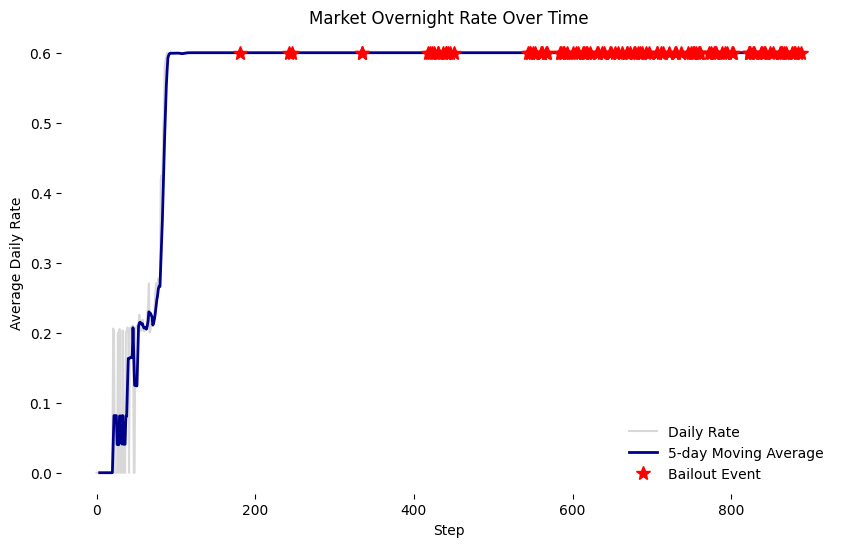

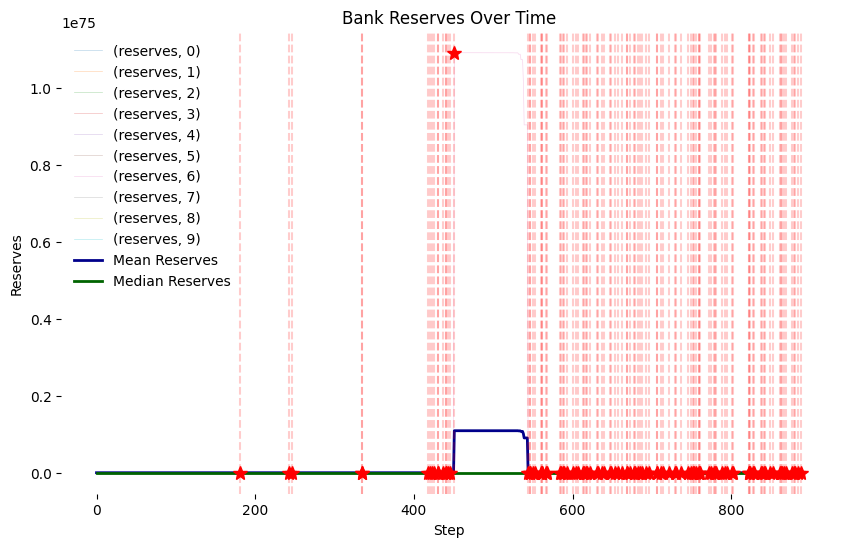

In [14]:
# For the market rate plot
plt.figure(figsize=(10, 6))
# Plot individual rates
plt.plot(financial_system_history['step'], financial_system_history['avg_daily_rate'], 
         alpha=0.3, color='gray', label='Daily Rate')
# Add rolling mean
rolling_mean = financial_system_history['avg_daily_rate'].rolling(window=5).mean()
plt.plot(financial_system_history['step'], rolling_mean, 
         color='darkblue', linewidth=2, label='5-day Moving Average')

# Add stars for bailout events
bailout_steps = financial_system_history[financial_system_history['fed_recapitalization'].apply(lambda x: x is not None and len(x) > 0)]['step']
bailout_rates = financial_system_history[financial_system_history['fed_recapitalization'].apply(lambda x: x is not None and len(x) > 0)]['avg_daily_rate']
plt.plot(bailout_steps, bailout_rates, '*', color='red', markersize=10, label='Bailout Event')

plt.title('Market Overnight Rate Over Time')
plt.xlabel('Step')
plt.ylabel('Average Daily Rate')
plt.legend(frameon=False)
sns.despine(left=True, bottom=True)
plt.show()

# For the reserves plot
plt.figure(figsize=(10, 6))
bank_wide = pd.pivot_table(bank_history, index=['step'], values=['reserves'], columns=['id'])

# Plot individual bank lines with low opacity
bank_wide.plot(linewidth=0.5, alpha=0.3, legend=None, ax=plt.gca())

# Add mean and median lines
plt.plot(bank_wide.index, bank_wide.mean(axis=1), 
         color='darkblue', linewidth=2, label='Mean Reserves')
plt.plot(bank_wide.index, bank_wide.median(axis=1), 
         color='darkgreen', linewidth=2, label='Median Reserves')

# Add stars for bailout events
for step in bailout_steps:
    plt.axvline(x=step, color='red', alpha=0.2, linestyle='--')
    plt.plot(step, bank_wide.loc[step].max(), '*', color='red', markersize=10)

plt.title('Bank Reserves Over Time')
plt.xlabel('Step')
plt.ylabel('Reserves')
plt.legend(frameon=False)
sns.despine(left=True, bottom=True)
plt.show()

These plots show the distribution of customer bank balances at the beginning of the simuation and the mean values at the end of the simulation steps.

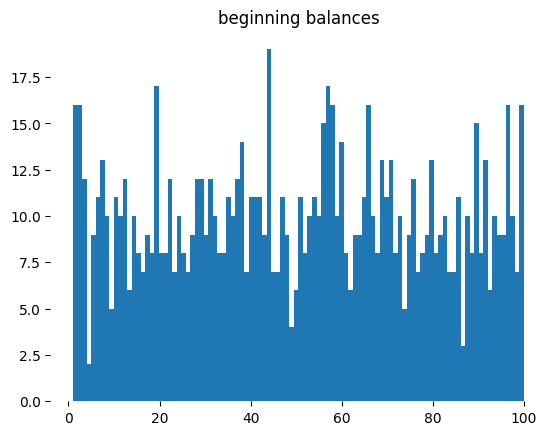

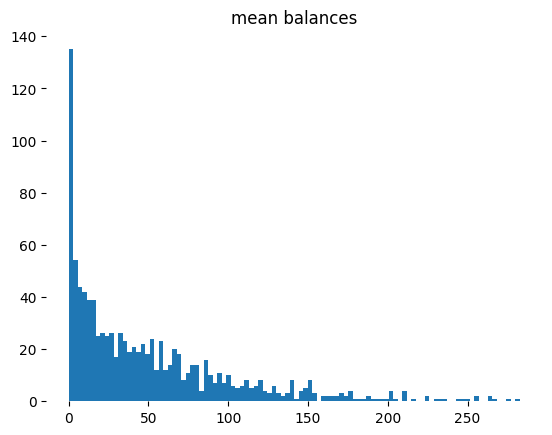

In [15]:
customer_history[customer_history['step'] == 0].hist('balance', bins = 100, grid=False)
plt.title('beginning balances')
sns.despine(left = True, bottom = True)
plt.show()

customer_history.groupby('id').mean().hist('balance', bins = 100, grid=False)
plt.title('mean balances')
sns.despine(left = True, bottom = True)

This new plot shows the movement of the market overnight rate over time.

,step,average_net_position,avg_daily_rate,average_risk_appetite,fed_recapitalization
0,0,0.000000e+00,0.0,0.000000,None
1,1,5.042685e-04,0.0,0.169369,[]
2,2,-2.984125e-03,0.0,0.169369,[]
3,3,-6.707229e-03,0.0,0.169369,[]
4,4,-7.288983e-03,0.0,0.169369,[]
...,...,...,...,...,...
884,884,-5.199351e+126,0.6,0.086852,"[(3, 110.00000000000001), (4, 110.000000000000..."
885,885,-8.241204e+127,0.6,0.086852,[]
886,886,-9.838760e+127,0.6,0.086852,[]
887,887,-1.319987e+128,0.6,0.086852,[]


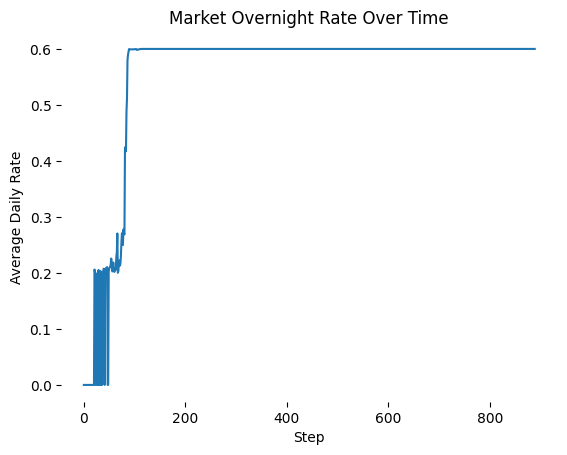

In [16]:
from IPython.display import display

display(financial_system_history)

plt.figure()
plt.plot(financial_system_history['step'], financial_system_history['avg_daily_rate'])
plt.title('Market Overnight Rate Over Time')
plt.xlabel('Step')
plt.ylabel('Average Daily Rate')
sns.despine(left=True, bottom=True)
plt.show()

This final plot shows, for each bank, mean reserve and loan values.

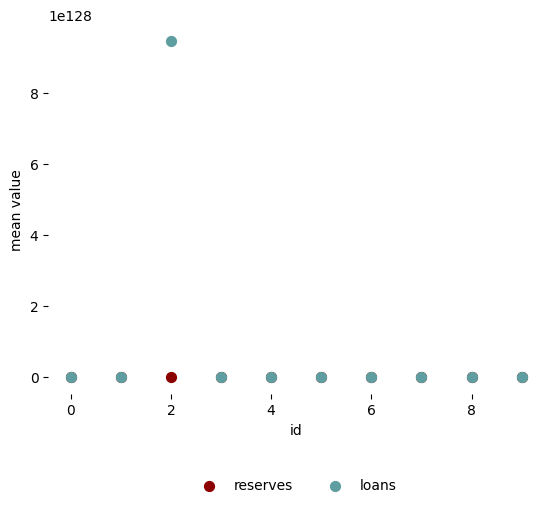

In [17]:
bank_means = bank_history[['id', 'reserves', 'loans']].groupby(by='id').mean()
bank_means = bank_means.reset_index()
ax = bank_means.plot.scatter(x = 'id', y = 'reserves', c = 'darkred', label = 'reserves', s = 50)
bank_means.plot.scatter(x = 'id', y = 'loans', c = 'cadetblue', label = 'loans', facecolors='none', s = 50, ax = ax)
plt.ylabel('mean value')
plt.legend(frameon=False, bbox_to_anchor=(0.5, -.3), loc='lower center', ncol=2)
sns.despine(left = True, bottom = True)

Letʻs see if we can discern what is happening with an animated plot

In [18]:
bank_history_output = widgets.Output()

def plot_bank_reserves_history():
    """Create an animated bar chart of bank reserves ordered by risk appetite"""
    with bank_history_output:
        clear_output(wait=True)
        plt.close('all')  # Close any existing figures
        
        # Create figure for animation
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Sort banks by risk appetite
        sorted_indices = sorted(range(len(risk_appetites)), key=lambda k: risk_appetites[k])
        sorted_appetites = [risk_appetites[i] for i in sorted_indices]
        
        # Calculate y-axis limits once
        all_reserves = [r for step_data in bank_history.groupby('step')['reserves'] for r in step_data[1]]
        y_min = min(all_reserves)
        y_max = min(50000, max(all_reserves))
        
        def update(frame):
            ax.clear()
            step_data = bank_history[bank_history['step'] == frame]
            
            # Get reserves for this step, sorted by risk appetite
            reserves = [step_data[step_data['id'] == i]['reserves'].values[0] for i in sorted_indices]
            
            # Create bar plot with color gradient
            colors = plt.cm.viridis(np.linspace(0, 1, len(reserves)))
            bars = ax.bar(range(len(reserves)), reserves, color=colors)
            
            # Set static y-axis limits
            ax.set_ylim(y_min, y_max)
            
            # Customize the plot
            ax.set_title(f'Bank Reserves by Risk Appetite (Step {frame})')
            ax.set_xlabel('Banks (ordered by risk appetite)')
            ax.set_ylabel('Reserves')
            
            # Set x-ticks to show risk appetites
            ax.set_xticks(range(len(sorted_appetites)))
            ax.set_xticklabels([f'{a:.2f}' for a in sorted_appetites], rotation=45)
            
            sns.despine(left=True, bottom=True)
            plt.tight_layout()
        
        # Create animation
        global bank_history_anim
        bank_history_anim = animation.FuncAnimation(
            fig,
            update,
            frames=bank_history['step'].unique(),
            interval=200,
            repeat=False
        )
        
        # Display the animation
        display(HTML(bank_history_anim.to_jshtml()))
        plt.close()



# autorun animation
display(bank_history_output)
plot_bank_reserves_history()




Output()